# **INTRODUZIONE:**
Le fake news negli ultimi anni si sono rivelate una problematica sempre più rilevante. Per rispondere all'esigenza di identificare e riconoscere le notizie false è possibile implementare metodologie avanzate di Natural Language Processing e Machine Learning.
In questo lavoro di tesi andrò a trattare e analizzare un dataset contenente titoli di notizie vere e false (https://github.com/KaiDMML/FakeNewsNet), al fine di valutare modelli per il riconoscimento automatico di fake news.
Il lavoro è articolato in più fasi, così riassumibili:
- Pre-processing dei dati: pulizia del dataset per permettere un'analisi accurata (compresa rimozione di stopwords e lemmatization).
- Sentiment classification: applicazione dei modelli di classificazione Multinomial e Bernoulli Naive Bayes, con estrazione di feature sia tramite CountVectorizer che TF-IDF e valutazione dei risultati.
- Resampling del dataset: riequilibrio delle classi per migliorare le prestazioni dei modelli e ripetizione dei test.
- Esplorazione della distribuzione delle parole nelle fake news: analisi del dataset tramite TextBlob e rappresentazione grafica.
- Sentiment analysis:  utilizzo del modello LDA implementato con Gensim per analizzare i principali topic all'interno delle fake news, rappresentazione visiva tramite pyLDAvis per una migliore comprensione.

La valutazione dei risultati è inserita via via nei blocchi di testo che accompagnano di codice.

Per prima cosa importo le librerie necessarie e carico i dati:

In [ ]:
! python3 -m pip install --user seaborn
! python3 -m pip install --user textblob
! python3 -m pip install --user scipy==1.12
! pip install gensim
! pip install pyLDAvis

In [ ]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt

import seaborn as sns
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fakenews.csv to fakenews (2).csv
Saving contractions.json to contractions (2).json


In [ ]:
data = pd.read_csv("fakenews.csv")
print(len(data), "rows:")
data.head(10)

23196 rows:


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
5,Gwen Stefani Got Dumped by Blake Shelton Over ...,www.intouchweekly.com/posts/gwen-stefani-dumpe...,www.intouchweekly.com,45,0
6,Broward County Sheriff Fired For Lying About P...,https://yournewswire.com/broward-county-sherif...,yournewswire.com,124,0
7,Amber Rose Shuts Down French Montana Dating Ru...,www.etonline.com/news/214798_amber_rose_shuts_...,www.etonline.com,4,0
8,Mindy Kaling makes first post-baby appearance ...,https://www.aol.com/article/entertainment/2018...,www.aol.com,59,1
9,Katharine McPhee Butchers Tony Nominations: “I...,https://www.98online.com/2018/05/02/katharine-...,www.98online.com,10,1


In [ ]:
title = data.columns.values[0]
real = data.columns.values[4]
title, real

('title', 'real')

# **PRE-PROCESSING DEI DATI:**

Per un'analisi efficace è importante pre-elaborare i dati, nello specifico procedo con le definizioni per la rimozione di stopwords e di lemmatizzazione, che poi implemento in una definizione generale per il pre-processing del dataset.
Finisco col visualizzare i risultati.

In [ ]:
import re #for using regular expressions
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words("english")
with open('contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']
from nltk import WordNetLemmatizer
#from nltk.stem import SnowballStemmer



def stopwords_removal(title):
    words = [w for w in title.split() if w not in stopwords]
    return " ".join(words)

def title_lemmatizer(title):
    lemma = WordNetLemmatizer()
    lemmatized_title = " ".join(lemma.lemmatize(w, pos='v') for w in title.split())
    return lemmatized_title
# alternative:
#def title_stemmer(title):
#    snowball = SnowballStemmer("english")
#    stemmed_title = " ".join([snowball.stem(w) for w in title.split()])
#   return stemmed_title

def process_title(title):
    title = title.lower()                                             # Lowercases the string
    title = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', title)   # Remove URLs
    title = re.sub(r"\d+", " ", str(title))                           # Removes all digits
    title = re.sub('&quot;'," ", title)                               # Remove (&quot;)
    title = re.sub(r"\b[a-zA-Z]\b", "", str(title))                   # Removes all single characters
    title = stopwords_removal(title)                                  # Removes stopwords (see function above)
#    title = title_stemmer(title)                                      # Stems the words (see function above)
    title = title_lemmatizer(title)                                   # Lemmatizes the words (see function above)

    #simple tokenization using split()
    for word in title.split():
        if word.lower() in contractions:
            title = title.replace(word, contractions[word.lower()])   # Replaces contractions (see list above)
    title = re.sub(r"[^\w\s]", " ", str(title))                       # Removes all remaining special chars
    title = re.sub(r'(.)\1+', r'\1\1', title)    # Convert more than 2 letter repetitions to 2 letter (e.g., cooool)
    title = re.sub(r"\s+", " ", str(title))      # Replaces extra spaces with a single space
    return title


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Controllo dei risultati:**

In [ ]:
data['clean_title'] = np.vectorize(process_title)(data[title])
data.insert(1, 'clean_title', data.pop('clean_title'))
data.head(10)

,title,clean_title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,kandi burruss explode rape accusation real hou...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,people choice award best red carpet look,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,sophia bush send sweet birthday message one tr...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,colombian singer maluma spark rumour inappropr...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,gossip girl years later upper east siders shoc...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1
5,Gwen Stefani Got Dumped by Blake Shelton Over ...,gwen stefani get dump blake shelton jealousy d...,www.intouchweekly.com/posts/gwen-stefani-dumpe...,www.intouchweekly.com,45,0
6,Broward County Sheriff Fired For Lying About P...,broward county sheriff fire lie parkland,https://yournewswire.com/broward-county-sherif...,yournewswire.com,124,0
7,Amber Rose Shuts Down French Montana Dating Ru...,amber rise shut french montana date rumors cal...,www.etonline.com/news/214798_amber_rose_shuts_...,www.etonline.com,4,0
8,Mindy Kaling makes first post-baby appearance ...,mindy kaling make first post baby appearance d...,https://www.aol.com/article/entertainment/2018...,www.aol.com,59,1
9,Katharine McPhee Butchers Tony Nominations: “I...,katharine mcphee butcher tony nominations drin...,https://www.98online.com/2018/05/02/katharine-...,www.98online.com,10,1


In [ ]:
clean_title = data['clean_title']

print(len(clean_title))

23196


# **SENTIMENT CLASSIFICATION:**

Per un'analisi più completa vettorizzo i dati sia con l'utilizzo di CountVectorizer che di TF-IDF, eseguo uno split in test set e training set e applico Multinomial e Bernoulli Naive Bayes.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigrams (single words) and Bigrams (two consecutive words)
final_vectorized_data = count_vectorizer.fit_transform(clean_title)

print(final_vectorized_data.toarray())

print(type(final_vectorized_data))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,3))
final_vectorized_data_TFIDF = tf_idf_vectorizer.fit_transform(clean_title)

print(final_vectorized_data_TFIDF.toarray())

print(type(final_vectorized_data_TFIDF))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
from sklearn.model_selection import train_test_split

#with CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, data[real],
                                                    test_size=0.2, random_state=69)

#test set's size is 20% of the whole dataset
#random_state: Controls the shuffling applied to the data before applying the split

#with TFIDF
X_train_TFIDF, X_test_TFIDF, y_train_TFIDF, y_test_TFIDF = train_test_split(final_vectorized_data_TFIDF, data[real],
                                                                            test_size=0.1, random_state=69)


In [ ]:
print("X_train_shape: ",X_train.shape)
print("X_test_shape: ",X_test.shape)
print("y_train_shape: ",y_train.shape)
print("y_test_shape: ",y_test.shape)
print("X_train_TFIDF_shape: ",X_train_TFIDF.shape)
print("X_test_TFIDF_shape: ",X_test_TFIDF.shape)
print("y_train_TFIDF_shape: ",y_train_TFIDF.shape)
print("y_test_TFIDF_shape: ",y_test_TFIDF.shape)


X_train_shape:  (18556, 118409)
X_test_shape:  (4640, 118409)
y_train_shape:  (18556,)
y_test_shape:  (4640,)
X_train_TFIDF_shape:  (20876, 241389)
X_test_TFIDF_shape:  (2320, 241389)
y_train_TFIDF_shape:  (20876,)
y_test_TFIDF_shape:  (2320,)


In [ ]:
from sklearn.naive_bayes import MultinomialNB  # Multinomial Naive Bayes Classifier
model_naive = MultinomialNB().fit(X_train, y_train)
model_naive_TFIDF = MultinomialNB().fit(X_train_TFIDF, y_train_TFIDF)
predicted_naive = model_naive.predict(X_test)
predicted_naive_TFIDF = model_naive_TFIDF.predict(X_test_TFIDF)

from sklearn.naive_bayes import BernoulliNB  # Bernoulli Naive Bayes
model_bernoulli = BernoulliNB().fit(X_train, y_train)
model_bernoulli_TFIDF = BernoulliNB().fit(X_train_TFIDF, y_train_TFIDF)
predicted_bernoulli = model_bernoulli.predict(X_test)
predicted_bernoulli_TFIDF = model_bernoulli_TFIDF.predict(X_test_TFIDF)

# **SENTIMENT CLASSIFICATION, PRIMI RISULTATI:**

E' il momento di valutare i risultati. Per farlo utilizzo il grafico Confusion Matrix, l' accuracy score e il classification report. Sarà sicuramente importante valutare la recall dei modelli sulle notizie false (0).

Già dai grafici si nota una bassa recall per le notizie classificate come false, i modelli hanno difficoltà a riconoscere come falsa una fake news quando la incontrano, l'opposto di quanto auspicabile. In tal senso MultinomialNB con l'utilizzo di CountVectorizer ha registrato i risultati migliori, riuscendo a riconoscere una fake news nel 65% dei casi. Per gli altri modelli, a fronte di una recall molto bassa (che va da 0.14 a 0.22), è invece da segnalare un alto valore della precision per le notizie false, che va da 0.84 fino a 0.90 nel caso di MultinomialNB con vettorizzazione TF-IDF. Significa che quando questi modelli rilevano una notizia come falsa generalmente lo è davvero. Possiamo però anche notare che i modelli stanno lavorando su un dataset sbilanciato, con una prevalenza di notizie vere. I punteggi di accuracy (che misura le previsioni corrette sul totale delle previsoni) sono buoni, come anche il grafico della curva di ROC (che rappresenta la performance al variare della soglia di decisione) ma risultano poco significativi proprio a fronte di questo sbilanciamento.

Risultati:

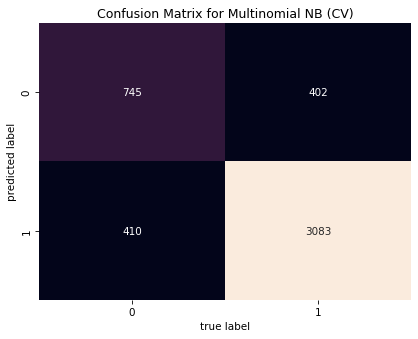

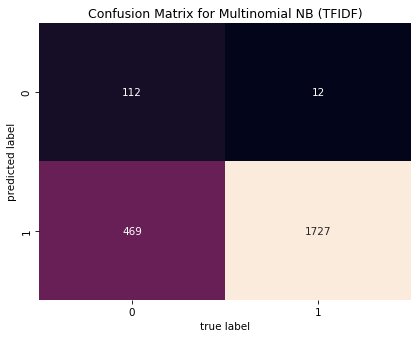

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=75)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Multinomial NB (CV)')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



plt.figure(dpi=75)
mat = confusion_matrix(y_test_TFIDF, predicted_naive_TFIDF)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Multinomial NB (TFIDF)')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

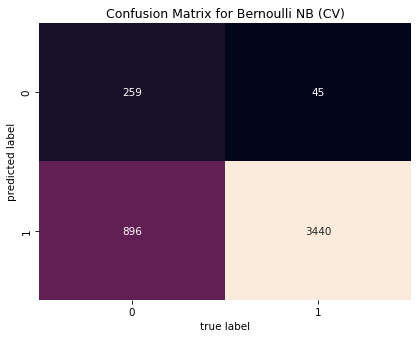

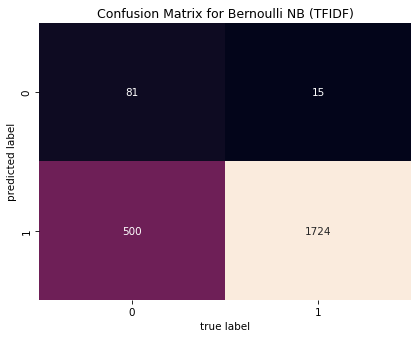

In [ ]:
plt.figure(dpi=75)
mat = confusion_matrix(y_test, predicted_bernoulli)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Bernoulli NB (CV)')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()



plt.figure(dpi=75)
mat = confusion_matrix(y_test_TFIDF, predicted_bernoulli_TFIDF)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Bernoulli NB (TFIDF)')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("MNB using CountVectorizer:")
print(classification_report(y_test, predicted_naive))
print("\n")
print("MNB using TFIDF:")
print(classification_report(y_test_TFIDF, predicted_naive_TFIDF))
print("\n")
print("BNB using CountVectorizer:")
print(classification_report(y_test, predicted_bernoulli))
print("\n")
print("BNB using TFIDF:")
print(classification_report(y_test_TFIDF, predicted_bernoulli_TFIDF))

MNB using CountVectorizer:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1155
           1       0.88      0.88      0.88      3485

    accuracy                           0.82      4640
   macro avg       0.77      0.76      0.77      4640
weighted avg       0.82      0.82      0.82      4640



MNB using TFIDF:
              precision    recall  f1-score   support

           0       0.90      0.19      0.32       581
           1       0.79      0.99      0.88      1739

    accuracy                           0.79      2320
   macro avg       0.84      0.59      0.60      2320
weighted avg       0.82      0.79      0.74      2320



BNB using CountVectorizer:
              precision    recall  f1-score   support

           0       0.85      0.22      0.36      1155
           1       0.79      0.99      0.88      3485

    accuracy                           0.80      4640
   macro avg       0.82      0.61      0.62      4640

In [ ]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test) # Accuracy = (TP + TN)/(TP + FP + TN + FN)
score_naive_TFIDF = accuracy_score(predicted_naive_TFIDF, y_test_TFIDF)
print("Accuracy with Naive-bayes:", score_naive)
print("Accuracy with Naive-bayes and TFIDF:", score_naive_TFIDF)
print("\n")
score_bernoulli = accuracy_score(predicted_bernoulli, y_test)
score_bernoulli_TFIDF = accuracy_score(predicted_bernoulli_TFIDF, y_test_TFIDF)
print("Accuracy with Bernoulli NB:", score_bernoulli)
print("Accuracy with Bernoulli NB and TFIDF:", score_bernoulli_TFIDF)
print("\n")

Accuracy with Naive-bayes: 0.825
Accuracy with Naive-bayes and TFIDF: 0.7926724137931035


Accuracy with Bernoulli NB: 0.7971982758620689
Accuracy with Bernoulli NB and TFIDF: 0.7780172413793104




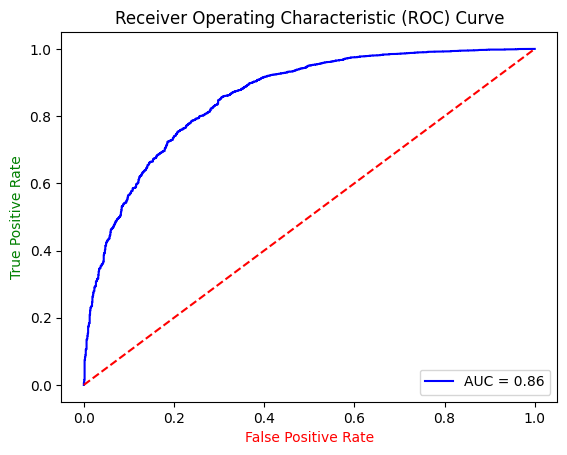

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr) #area under the curve
plt.figure(dpi=100) # to plot high quality graph
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

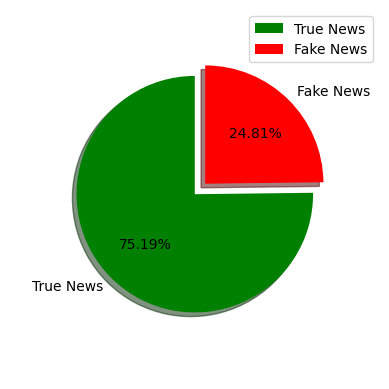

In [ ]:
sentiments = ['True News', 'Fake News']
#1 for real and 0 for fake news
slices = [(data[real] != 0).sum(), (data[real] == 0).sum()]
colors = ['g', 'r']
plt.pie(slices, labels=sentiments, colors=colors, startangle=90, shadow=True,
        explode=(0, 0.1), radius=0.8, autopct='%1.2f%%')
plt.legend()
plt.show()

# **MIGLIORARE I RISULTATI COL RESAMPLING:**

Il grafico sopra è rappresentativo della situazione, magari andando a equilibrare il dataset i risultati ottenuti saranno migliori. Procedo quindi con un resample tramite undersampling: creo un nuovo dataset dove le notizie vere sono scelte casualmente fino ad arrivare allo stesso numero di quelle false, il resto vengono scartate. Una volta fatto vettorizzo il dataset bilanciato e ripeto i test.

In [ ]:
from sklearn.utils import resample

true_class = data[data['real'] == 1]
false_class = data[data['real'] == 0]

true_class_downsampled = resample(true_class,
                                  replace=False,
                                  n_samples=len(false_class),  # equalization
                                  random_state=42)

balanced_data = pd.concat([true_class_downsampled, false_class])

# vectorization
X_balanced = balanced_data['clean_title']
y_balanced = balanced_data['real']

**Nuova situazione:**

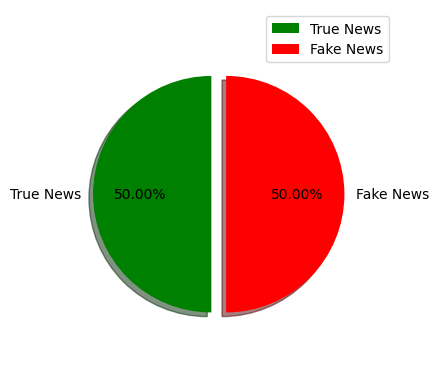

In [ ]:
sentiments_balanced = ['True News', 'Fake News']
#1 for real and 0 for fake news
slices = [(balanced_data[real] != 0).sum(), (balanced_data[real] == 0).sum()]
colors = ['g', 'r']
plt.pie(slices, labels=sentiments, colors=colors, startangle=90, shadow=True,
        explode=(0, 0.1), radius=0.8, autopct='%1.2f%%')
plt.legend()
plt.show()

In [ ]:
# CountVectorizer
vectorizer_count = CountVectorizer(ngram_range=(1,2))
X_balanced_vectorized = vectorizer_count.fit_transform(X_balanced)

# TFIDF Vectorizer
vectorizer_tfidf = TfidfVectorizer(use_idf = True, ngram_range=(1,3))
X_balanced_tfidf = vectorizer_tfidf.fit_transform(X_balanced)

In [ ]:
# CountVectorizer
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced_vectorized, y_balanced, test_size=0.2, random_state=69)

# TFIDF
X_train_tfidf_balanced, X_test_tfidf_balanced, y_train_tfidf_balanced, y_test_tfidf_balanced = train_test_split(
    X_balanced_tfidf, y_balanced, test_size=0.2, random_state=69)

In [ ]:
print("X_train_balanced_shape: ",X_train_balanced.shape)
print("X_test_shape: ",X_test_balanced.shape)
print("y_train_shape: ",y_train_balanced.shape)
print("y_test_shape: ",y_test_balanced.shape)
print("X_train_TFIDF_shape: ",X_train_tfidf_balanced.shape)
print("X_test_TFIDF_shape: ",X_test_tfidf_balanced.shape)
print("y_train_TFIDF_shape: ",y_train_tfidf_balanced.shape)
print("y_test_TFIDF_shape: ",y_test_tfidf_balanced.shape)

X_train_balanced_shape:  (9208, 66214)
X_test_shape:  (2302, 66214)
y_train_shape:  (9208,)
y_test_shape:  (2302,)
X_train_TFIDF_shape:  (9208, 128860)
X_test_TFIDF_shape:  (2302, 128860)
y_train_TFIDF_shape:  (9208,)
y_test_TFIDF_shape:  (2302,)


In [ ]:
# Multinomial Naive Bayes - CountVectorizer
model_naive_balanced = MultinomialNB().fit(X_train_balanced, y_train_balanced)
predicted_naive_balanced = model_naive_balanced.predict(X_test_balanced)

# Multinomial Naive Bayes - TFIDF
model_naive_tfidf_balanced = MultinomialNB().fit(X_train_tfidf_balanced, y_train_tfidf_balanced)
predicted_naive_tfidf_balanced = model_naive_tfidf_balanced.predict(X_test_tfidf_balanced)

# Bernoulli Naive Bayes - CountVectorizer
model_bernoulli_balanced = BernoulliNB().fit(X_train_balanced, y_train_balanced)
predicted_bernoulli_balanced = model_bernoulli_balanced.predict(X_test_balanced)

# Bernoulli Naive Bayes - TFIDF
model_bernoulli_tfidf_balanced = BernoulliNB().fit(X_train_tfidf_balanced, y_train_tfidf_balanced)
predicted_bernoulli_tfidf_balanced = model_bernoulli_tfidf_balanced.predict(X_test_tfidf_balanced)

# **VALUTAZIONE DEI NUOVI RISULTATI:**

La recall sulle notizie false è migliorata di molto in tutti i modelli e l'accuracy è rimasta buona (∼0.79), esattamente il risultato auspicato.

Nello specifico la recall per le notizie false adesso va da 0.80 fino a 0.84 nel caso dei modelli MultinomialNB. In generale i modelli sembrano robusti, tutti fanno registrare risultati equiparabili, con buoni livelli di precision, recall e accuracy, senza incontrare criticità particolari. Anche il grafico della curva ROC continua a dare buoni risultati, migliorando leggermente.

Risultati:

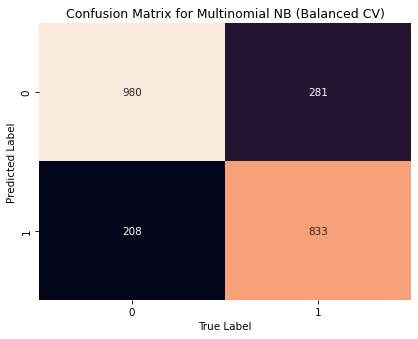

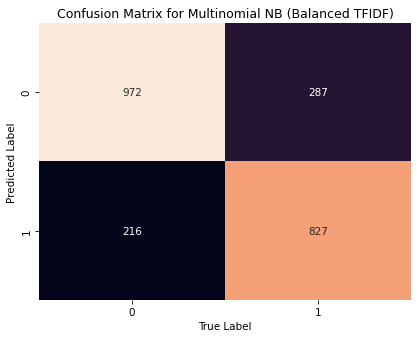

In [ ]:
# Confusion Matrix  - Multinomial NB - CV
plt.figure(dpi=75)
mat = confusion_matrix(y_test_balanced, predicted_naive_balanced)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Multinomial NB (Balanced CV)')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

# Confusion Matrix  - Multinomial NB - TFIDF
plt.figure(dpi=75)
mat = confusion_matrix(y_test_tfidf_balanced, predicted_naive_tfidf_balanced)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Multinomial NB (Balanced TFIDF)')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

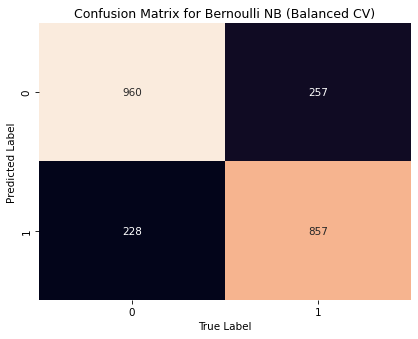

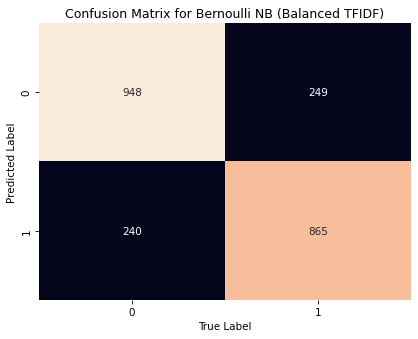

In [ ]:
# Confusion Matrix - Bernoulli NB - CountVectorizer
plt.figure(dpi=75)
mat = confusion_matrix(y_test_balanced, predicted_bernoulli_balanced)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Bernoulli NB (Balanced CV)')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

# Confusion Matrix - Bernoulli NB - TFIDF
plt.figure(dpi=75)
mat = confusion_matrix(y_test_tfidf_balanced, predicted_bernoulli_tfidf_balanced)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Bernoulli NB (Balanced TFIDF)')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

In [ ]:
# Multinomial Naive Bayes - CountVectorizer
print("MNB using Balanced CountVectorizer:")
print(classification_report(y_test_balanced, predicted_naive_balanced))
print("\n")

# Multinomial Naive Bayes - TFIDF
print("MNB using Balanced TFIDF:")
print(classification_report(y_test_tfidf_balanced, predicted_naive_tfidf_balanced))
print("\n")

# Bernoulli Naive Bayes - CountVectorizer
print("BNB using Balanced CountVectorizer:")
print(classification_report(y_test_balanced, predicted_bernoulli_balanced))
print("\n")

# Bernoulli Naive Bayes - TFIDF
print("BNB using Balanced TFIDF:")
print(classification_report(y_test_tfidf_balanced, predicted_bernoulli_tfidf_balanced))
print("\n")

MNB using Balanced CountVectorizer:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1188
           1       0.80      0.75      0.77      1114

    accuracy                           0.79      2302
   macro avg       0.79      0.79      0.79      2302
weighted avg       0.79      0.79      0.79      2302



MNB using Balanced TFIDF:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1188
           1       0.79      0.74      0.77      1114

    accuracy                           0.78      2302
   macro avg       0.78      0.78      0.78      2302
weighted avg       0.78      0.78      0.78      2302



BNB using Balanced CountVectorizer:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1188
           1       0.79      0.77      0.78      1114

    accuracy                           0.79      2302
   macro avg       0.79   

In [ ]:
score_naive_balanced = accuracy_score(predicted_naive_balanced, y_test_balanced)
score_naive_tfidf_balanced = accuracy_score(predicted_naive_tfidf_balanced, y_test_tfidf_balanced)
print("Accuracy with Naive-bayes on Balanced Data (CV):", score_naive_balanced)
print("Accuracy with Naive-bayes on Balanced Data (TFIDF):", score_naive_tfidf_balanced)
print("\n")
score_bernoulli_balanced = accuracy_score(predicted_bernoulli_balanced, y_test_balanced)
score_bernoulli_tfidf_balanced = accuracy_score(predicted_bernoulli_tfidf_balanced, y_test_tfidf_balanced)
print("Accuracy with Bernoulli NB on Balanced Data (CV):", score_bernoulli_balanced)
print("Accuracy with Bernoulli NB on Balanced Data (TFIDF):", score_bernoulli_tfidf_balanced)
print("\n")

Accuracy with Naive-bayes on Balanced Data (CV): 0.7875760208514335
Accuracy with Naive-bayes on Balanced Data (TFIDF): 0.7814943527367506


Accuracy with Bernoulli NB on Balanced Data (CV): 0.7893136403127715
Accuracy with Bernoulli NB on Balanced Data (TFIDF): 0.7875760208514335




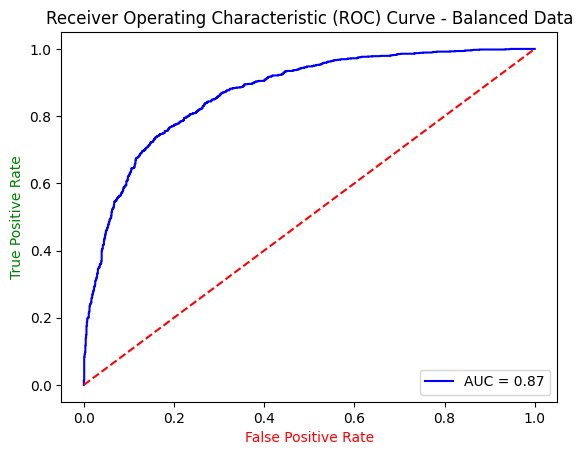

In [ ]:
probs_balanced = model_naive_balanced.predict_proba(X_test_balanced)
preds_balanced = probs_balanced[:, 1]

fpr_balanced, tpr_balanced, threshold_balanced = roc_curve(y_test_balanced, preds_balanced)

roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

# ROC
plt.figure(dpi=100)
plt.title('Receiver Operating Characteristic (ROC) Curve - Balanced Data')
plt.plot(fpr_balanced, tpr_balanced, 'b', label='AUC = %0.2f' % roc_auc_balanced)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.show()

# **DISTRIBUZIONE DELLE PAROLE NELLE FAKE NEWS**:

Adesso può essere interessante andare ad analizzare come sono distribuite le parole nei titoli di fake news.
Per farlo utilizzo Textblob e suddivido le fake news in positive e negative, settando subjectivity a 0.5 e polarity a + e -0.5. Così suddivise risulta un equilibrio tra titoli di carattere positivo (121) e negativo (126). Tra le parole più utilizzate si notano diversi nomi di celebrità, a sottolineare come il gossip sia in questo dataset la prima fonte di fake news. Tra i termini negativi si trovano parole che esprimono un senso di curiosità e di urgenza in chi legge, come "desperate" o "sick", curiosità che viene stimolata anche nei titoli positivi con parole come "welcome" o "baby". Queste caratteristiche si possono ricondurre a una strategia di "clickbait". Dai grafici di distribuzione delle parole troviamo situazioni analoghe tra titoli di carattere positivo e negativo. L'utilizzo di poche parole è più frequente, mentre dal log-log plot si osserva una situazione asimmetrica con una pendenza molto ripida (skewed distribution), riconducibile al concetto di power law.

In [ ]:
from textblob import TextBlob
fake_news_data = data[data['real'] == 0]

positive_titles = []
negative_titles = []

for i in range(0, len(fake_news_data['clean_title'])):
    text = fake_news_data['clean_title'].iloc[i]
    text_blob = TextBlob(text)
    subjectivity = text_blob.subjectivity
    polarity = text_blob.polarity

    # Categories
    if (subjectivity > 0.5) and polarity > 0.5:
        positive_titles.append(text)
    elif (subjectivity > 0.5) and polarity < -0.5:
        negative_titles.append(text)

In [ ]:
print("Positive fake titles: ", len(positive_titles))
for i in range(0, 10):
    print(positive_titles[i])
print("\n")
print("Negative fake titles: ", len(negative_titles))
for i in range(0, 10):
    print(negative_titles[i])

Positive fake titles:  121
latest three billboards win best drama film globe
jay leave nightclub staff tip people aren happy
caitlyn jenner simpson set reunite tv it would fascinating exclusive 
donald trump welcome harry potter curse child say play hermione
jay tour prove goat still greatest
history kanye west kardashians feud amber rose blac chyna
would think kylie would successful kardashian 
photos meghan markle gorgeous wed ring
miley cyrus she struggle buy perfect holiday gift liam hemsworth
brad pitt happy angelina


Negative fake titles:  126
kim kardashian insist sick kanye west go hospital saint pneumonia scare source
no zayn desperate defend girlfriend gigi hadid
robert pattinson desperately want bond kristen stewart
angelina jolie dirt diary brad pitt boozing violent rag volatile behavior source claim
celebrities slam trump decision end daca callous disgusting grave mistake 
rihanna awkward exes leonardo drake avoid pre oscars bash
justin bieber selena gomez relationship ru

In [ ]:
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def process_text(clean_titles):
    tokens = []
    for title in clean_titles:
        toks = word_tokenize(title)
        toks = [t for t in toks if t.lower() not in stopwords]
        # Aggiungi i token alla lista finale
        tokens.extend(toks)

    return tokens

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Top 10 positive words in fake news titles:
[('welcome', 17), ('happy', 13), ('jenner', 13), ('baby', 11), ('justin', 10), ('good', 10), ('jennifer', 10), ('would', 9), ('kylie', 9), ('cover', 8)]


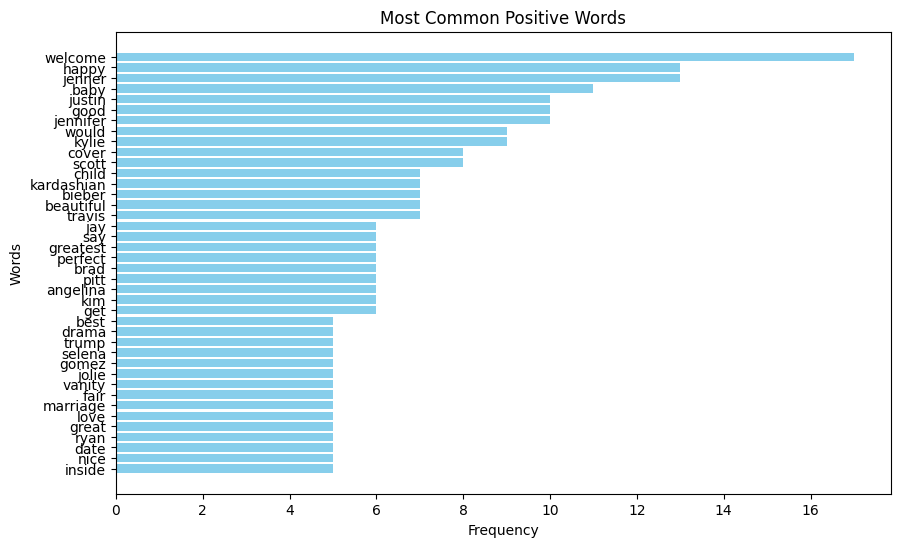



Top 10 negative words in fake news titles:
[('kim', 19), ('kardashian', 17), ('desperate', 15), ('justin', 14), ('jennifer', 13), ('jenner', 11), ('get', 11), ('aniston', 10), ('sick', 8), ('awkward', 8)]


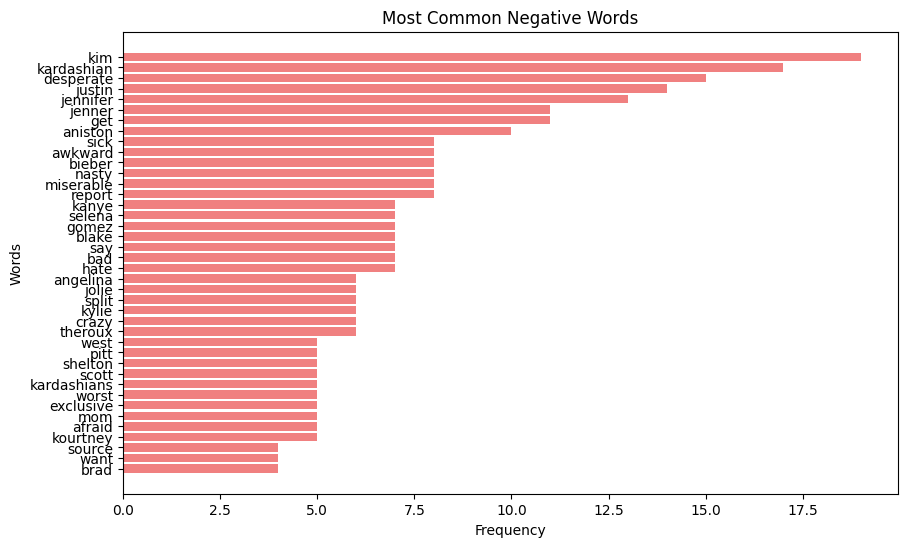

In [ ]:
import matplotlib.pyplot as plt

pos_tokens = process_text(positive_titles)
pos_freq = nltk.FreqDist(pos_tokens)
neg_tokens = process_text(negative_titles)
neg_freq = nltk.FreqDist(neg_tokens)

print("Top 10 positive words in fake news titles:")
print(pos_freq.most_common(10))


pos_words, pos_freqs = zip(*pos_freq.most_common(40))

plt.figure(figsize=(10, 6))
plt.barh(pos_words, pos_freqs, color='skyblue')

plt.title('Most Common Positive Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.show()
print("\n")
print("Top 10 negative words in fake news titles:")
print(neg_freq.most_common(10))
neg_words, neg_freqs = zip(*neg_freq.most_common(40))

plt.figure(figsize=(10, 6))
plt.barh(neg_words, neg_freqs, color='lightcoral')

plt.title('Most Common Negative Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.show()
print("\n")

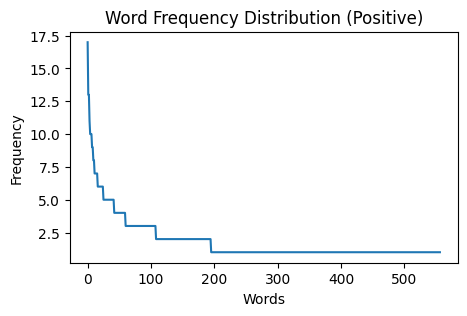

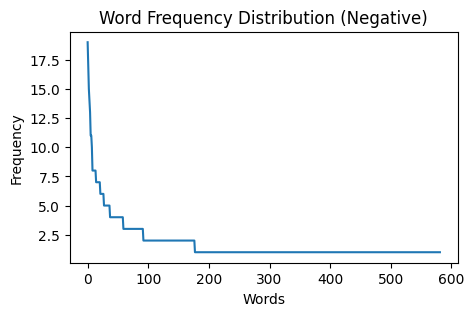

In [ ]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(5,3))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

y_val_neg = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(5,3))
plt.plot(y_val_neg)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

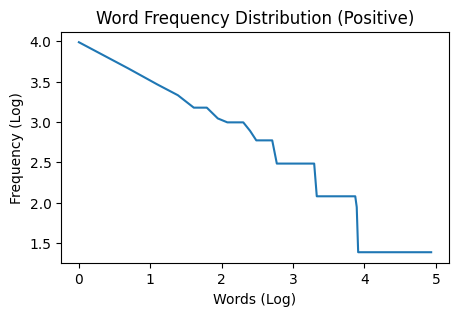

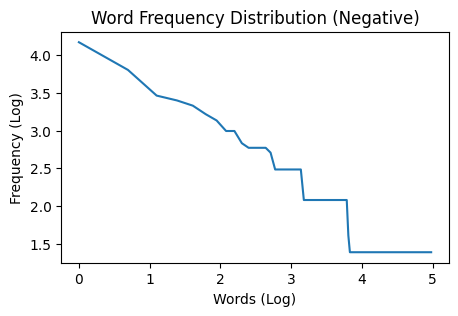

In [ ]:
import math

y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(5,3))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

y_final_neg = []
for i, k, z, t in zip(y_val_neg[0::4], y_val_neg[1::4], y_val_neg[2::4], y_val_neg[3::4]):
    y_final_neg.append(math.log(i + k + z + t))

x_val_neg = [math.log(i + 1) for i in range(len(y_final_neg))]

fig = plt.figure(figsize=(5,3))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val_neg, y_final_neg)
plt.show()

# **SENTIMENT ANALYSIS DELLE FAKE NEWS:**

Tramite Gensim procedo alla sentiment analysis delle fake news.
L'analisi dei topic conferma la predominanza di notizie a tema gossip.
Una volta creato il dizionario, ho implementato il modello LDA. Seguendo i punteggi di Perplexity score (quanto bene il modello prevede i dati) e Choerence Score (coerenza semantica delle parole principali associate a ciascun tema),
13 temi sembrava essere una scelta promettente, poiché offre il punteggio di Coherence Score più alto (0.45) pur avendo una
Perplexity più alta rispetto ad altre scelte. Analizzando la situazione con PLDAvis però si nota subito che questo numero è sicuramente eccessivo, data la grossa sovrapposizione dei temi. Ho quindi concluso che 3 temi dovrebbero garantire la migliore suddivisione. Da questa scelta ho potuto dedurre che il 40.7% delle fake news nel dataset sembra riguardare notizie su divorzi, matrimoni e flirt di personaggi famosi, il 32% notizie su gravidanze e il 27.3% notizie sulla famiglia Kardashian e i loro rapporti con la politica e con altri personaggi famosi.

In [ ]:
import gensim

from gensim import corpora
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield simple_preprocess(str(sentence))  # Gensim preprocessing

fake_news = data[data['real'] == 0]
data_words_fake_news = list(sent_to_words(fake_news['clean_title']))

print(data_words_fake_news[:3])

[['gwen', 'stefani', 'get', 'dump', 'blake', 'shelton', 'jealousy', 'drama', 'exclusive'], ['broward', 'county', 'sheriff', 'fire', 'lie', 'parkland'], ['amber', 'rise', 'shut', 'french', 'montana', 'date', 'rumors', 'call', 'rapper', 'bruvaa']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_fake_news)

corpus = [id2word.doc2bow(t) for t in data_words_fake_news]

print("Corpus:")
print(corpus[:3])
print("\n")
print("Corpus in a human readable form:")
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]])

Corpus:
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)], [(15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]


Corpus in a human readable form:
[[('blake', 1), ('drama', 1), ('dump', 1), ('exclusive', 1), ('get', 1), ('gwen', 1), ('jealousy', 1), ('shelton', 1), ('stefani', 1)], [('broward', 1), ('county', 1), ('fire', 1), ('lie', 1), ('parkland', 1), ('sheriff', 1)], [('amber', 1), ('bruvaa', 1), ('call', 1), ('date', 1), ('french', 1), ('montana', 1), ('rapper', 1), ('rise', 1), ('rumors', 1), ('shut', 1)]]


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,  #K num. of topics
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto', # the hyperparameter alpha of the per-document topic distribution is automatically estimated by the model
                                           per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.035*"kardashian" + 0.020*"kim" + 0.016*"trump" + 0.014*"kanye" + 0.013*"west" + 0.009*"star" + 0.007*"donald" + 0.007*"khloe" + 0.006*"ben" + 0.006*"affleck"'), (1, '0.015*"baby" + 0.013*"meghan" + 0.011*"blake" + 0.011*"markle" + 0.010*"shelton" + 0.010*"wed" + 0.010*"gwen" + 0.009*"stefani" + 0.009*"say" + 0.008*"kate"'), (2, '0.021*"jennifer" + 0.020*"brad" + 0.019*"pitt" + 0.018*"jenner" + 0.016*"justin" + 0.015*"angelina" + 0.015*"jolie" + 0.013*"aniston" + 0.011*"selena" + 0.010*"gomez"')]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_fake_news, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.997881200665583

Coherence Score:  0.35637393550669333


In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.209958  0.169598       1        1  40.662081
1      0.051897 -0.255038       2        1  32.014393
0     -0.261855  0.085440       3        1  27.323526, topic_info=           Term        Freq       Total Category  logprob  loglift
110  kardashian  450.000000  450.000000  Default  30.0000  30.0000
170    jennifer  407.000000  407.000000  Default  29.0000  29.0000
50         brad  394.000000  394.000000  Default  28.0000  28.0000
111         kim  265.000000  265.000000  Default  27.0000  27.0000
53         pitt  363.000000  363.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
153       hadid   48.978820   49.733787   Topic3  -5.5754   1.2821
253        best   43.478296   44.155251   Topic3  -5.6945   1.2820
148          us   45.311558   46.032006   Topic3  -5.6532   1.2816
122       scott   58.049309  142.426489   Topic3  -5.4055   0.3999
641        find   44.820016   56.190388   Topic3  -5.6641   1.0713

[137 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
139       3  0.986129   affleck
357       3  0.992121      alex
49        1  0.998395  angelina
336       1  0.998420   aniston
69        2  0.998524      baby
...     ...       ...       ...
148       3  0.977581        us
67        2  0.995352       wed
117       3  0.997479      west
463       3  0.990176     worth
761       2  0.994522      year

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])